In [1]:
%run "../../../common/0_notebooks_base_setup.py"    

/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Estadística Inferencial - Test de Hipótesis

<a id="section_toc"></a> 
## Tabla de Contenidos


[Intro](#section_intro)

[Imports](#section_imports)

[Recordemos de la notebook de Probabilidad](#section_repaso)

[H0 y H1](#section_H0_H1)

[Pasos en un test de hipótesis](#section_pasos)

[p-value](#section_pvalue)

[Teorema central del límite](#section_tcl)

[Ejemplo de test de hipótesis para la media poblacional](#section_ejemplo_test_media_poblacional)

[Test de hipótesis para una población](#section_test_una_poblacion)

$\hspace{.5cm}$[Especificación de las hipótesis nula y alternativa](#section_especificacion_H0_H1)

$\hspace{.5cm}$[Tests para la media de una población normal con varianza conocida](#section_test_media_poblacion_normal_varianza_conocida)

$\hspace{.5cm}$[Tests para la media de una población normal con varianza desconocida](#section_test_media_poblacion_normal_varianza_desconocida)

$\hspace{.5cm}$[Test para la proporción](#section_test_proporcion)

$\hspace{.5cm}$[Interpretación del nivel de significación de un test](#section_interpretacion_alfa)

[En resumen](#section_resumen)

[Tipos de error en test de hipótesis](#section_tipos_error)

[A/B Testing](#section_ab_testing)



<a id="section_intro"></a> 
## Intro

[volver a TOC](#section_toc)

Dentro de la inferencia estadística, un contraste de hipótesis (también denominado test de hipótesis o prueba de significación) es un procedimiento para decidir si una propiedad que se supone en una población estadística es compatible con lo observado en una muestra de dicha población.



<a id="section_imports"></a> 
## Imports

[volver a TOC](#section_toc)


In [2]:
import scipy.stats as stats
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<a id="section_repaso"></a> 
## Recordemos de la notebook de Probabilidad

[volver a TOC](#section_toc)


La **distribución de probabilidad de una variable aleatoria X**, también llamada **función de distribución** de X es la función $F_X(x)$, que asigna a cada evento definido sobre la variable aleatoria $X$ una probabilidad dada por la siguiente expresión:

\begin{equation}
  F_X(x) = P(X \le x)
\end{equation}

Usando `scipy.stats`, `stats.norm.cdf(z)` calcula  $F_X(z)$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html


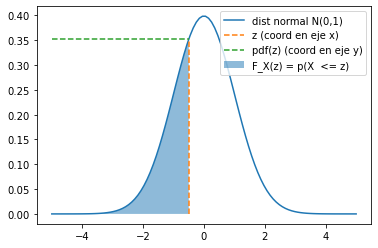

In [3]:
z = -0.5

# Plot the normal distribution
samples = 100
x_plot = np.linspace(-5, 5, samples)
y_plot = stats.norm.pdf(x_plot, 0, 1)
plt.plot(x_plot, y_plot)

# Plot the critical region
x_crit = np.linspace(-5, z, samples)
y_crit = stats.norm.pdf(x_crit, 0, 1)
# colorea la region de rechazo de H0:
plt.fill_between(x_crit,  y_crit, alpha=.5)

# Plot the z score, linea naranja:
plt.plot([z, z], [0, stats.norm.pdf(z)], '--')

plt.plot([-5, z], [stats.norm.pdf(z), stats.norm.pdf(z)], '--')

# Show legend
plt.legend(['dist normal N(0,1)', 'z (coord en eje x)', 'pdf(z) (coord en eje y)', 'F_X(z) = p(X  <= z)'])
plt.show()


Si dado una valor alfa de probabilidad acumulada $F_X(x) = \alpha $ queremos saber cuál es el valor de x que corresponde a ese valor de $\alpha$ usamos `stats.norm.ppf`

`stats.norm.ppf(alfa)` devuelve un valor $z$, cuyo probabilidad acumulada $F_X(z)$ es igual a $\alpha $

<a id="section_H0_H1"></a> 
## H0 y H1

[volver a TOC](#section_toc)


Se denomina hipótesis nula $H_{0}$, a la hipótesis que se desea contrastar, que identificamos con la hipótesis de no cambio, no diferencia, no mejora, etc. 

$H_{0}$ representa la hipótesis que mantendremos a no ser que los datos indiquen su falsedad. 

La hipótesis $H_{0}$ nunca se considera probada, aunque sí puede ser rechazada por los datos. 

A partir de una muestra de la población en estudio, se extrae un estadístico (esto es, un valor que es función de la muestra) cuya distribución de probabilidad esté relacionada con la hipótesis en estudio y sea conocida. 

Definimos como región de rechazo al conjunto de valores que es más improbable bajo la hipótesis $H_{0}$, esto es el conjunto de valores para el que rechazaremos la hipótesis nula si el valor del estadístico observado pertenece a ese conjunto.

La probabilidad de que se obtenga un valor del estadístico que esté en la región de rechazo aun siendo cierta la hipótesis nula puede calcularse. De esta manera, se puede escoger dicha región de tal forma que la probabilidad de cometer este error sea suficientemente pequeña.

<a id="section_pasos"></a> 
## Pasos en un test de hipótesis

[volver a TOC](#section_toc)


1) Formular las hipótesis nula (H0) y alternativa (H1).

2) Identificar el estadístico de prueba  apropiado y su distribución bajo la hipótesis nula (asumiendo que ésta es cierta).

3) Fijar el nivel de significación (la probabilidad de equivocarme al rechazar H0 que estoy dispuesto a tolerar).

4) Establecer la regla de decisión (dado el nivel de significación, calculamos valores críticos que separan la región de no rechazo de la de rechazo).

5) Recolectar datos y calcular el valor muestral del estadístico de prueba.

6) Tomar la decisión estadística.

En forma general:

$${estadistico \text{ } de \text{ } test} = \frac{estadistico \text{ } muestral \text{ }-\text{ }valor \text{ } del \text{ } parametro \text{ }poblacional \text{ } bajo \text{ }H_0}{error \text{ } estandar \text{ } del \text{ } estadistico \text{ } muestral}$$


<a id="section_pvalue"></a> 
## p-value

[volver a TOC](#section_toc)


El p-value es la probabilidad de obtener el valor observado o valores más extremos del estadístico de prueba si la hipótesis nula fuese cierta.

Si p-value es menor que nivel de significación (alfa), entonces rechazo H0. 

Esta es una forma alternativa de fijar la regla de decisión, sin calcular los valores críticos.


<a id="section_tcl"></a> 
## Teorema central del límite

[volver a TOC](#section_toc)


Sea $X_1, X_2, ..., X_n$ un conjunto de variables aleatorias, independientes e identicamente distribuídas de una distribución con media $\mu$ y varianza $\sigma^2 \neq 0$. Entonces si $n$ es suficientemente grande, la variable aleatoria $\hat{X} = \frac{1}{n} \sum _{i=1}^{n}{X_i}$ tiene aproximadamente una distribución normal con $\mu_{\hat{X}} = \mu$ y ${\sigma_{\hat{X}}^2} = {\frac{\sigma^2}{n}}$



---

<a id="section_ejemplo_test_media_poblacional"></a> 
## Ejemplo de test de hipótesis para la media poblacional

[volver a TOC](#section_toc)



Un investigador de mercados y hábitos de comportamiento afirma que el tiempo que los niños de tres a cinco años dedican a ver la televisión cada semana es en promedio **22 horas**. 

Frente a este estudio, una empresa de investigación de mercados cree que la media es mayor y para probar su hipótesis toma una **muestra de 64 observaciones** procedentes de la misma población, obteniendo como resultado una **media de 25 y desvío estándar de 6 horas**. 

Verifique si la afirmación del investigador es realmente cierta utilizando un **nivel de significación del 5%**.

¿Qué sabemos? 
- Tenemos una hipótesis sobre la media poblacional
- Tenemos una muestra
- Queremos saber si la muestra nos puede proveer evidencia para rechazar nuestra hipótesis sobre la media poblacional.

Queremos saber si la muestra nos puede proveer evidencia para rechazar nuestra hipótesis sobre la media poblacional.

Planteamos las hipótesis ($\mu$ el la media poblacional):

H0: $\mu$ = 22

H1: $\mu$ > 22

Por TCL y suponiendo H0 verdadera, la media muestral tiene distribución normal con media 22 y sigma = 6 / sqrt(64). 

Entonces la variable aleatoria $Z = \frac{media\text{ }muestral - media\text{ }H0}{\sigma / \sqrt{n}}$ tiene distribución $N(0,1)$ y podemos calcular valores críticos usando `stats.norm.cdf` que dado un valor de Z nos devuelve la probabilidad acumulada para ese Z

https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.norm.html


In [4]:
media_muestral = 25
media_H0 = 22
sd = 6
n = 64

#construimos el estadístico de test Z:
Z = (media_muestral - media_H0 ) / (sd/math.sqrt(n))
print('estadístico de test:', Z)

alpha = 0.05
print('nivel de significación:', alpha)


estadístico de test: 4.0
nivel de significación: 0.05


Calculemos la probabilidad de obtener un valor de 4 o más extremo para Z dado que Z tiene distribución $N(0, 1)$

Prob(Z >= 4) = 1 - Prob(Z < 4) = 1 - `stats.norm.cdf(Z)`

In [5]:
1 - stats.norm.cdf(Z)

3.167124183311998e-05

Que resulta en un numero muy chico. Esto quiere decir que si H0 es verdadera, es muy baja la probabilidad de encontrar un valor de 4 (que corresponde a la media muestral de 25) o más. Y como este número es menor a 0.05 que es el nivel de significación del test, entonces rechazamos H0.

Podemos llegar a la misma conclusión de otra forma. Calculemos ahora los valores que definen la región de rechazo y grafiquemos.

`stats.norm.ppf` recibe como parámetro una valor para alpha y devuelve el valor de Z cuya probabilidad acumulada es alpha.

In [6]:
# necesitamos el valor de Z por derecha, hacemos 1 - significación o equivalentemente multipliamos por -1 el resultado con el alpha de 0.05
alpha = 1 - 0.05
z_critico = stats.norm.ppf(alpha)
z_critico

1.6448536269514722

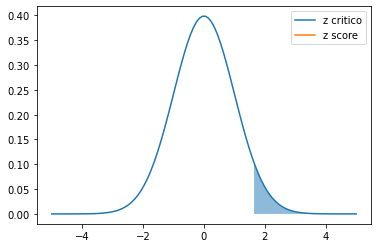

In [7]:
critical_value = z_critico

# Plot the normal distribution
samples = 100
x_plot = np.linspace(-5, 5, samples)
y_plot = stats.norm.pdf(x_plot, 0, 1)
plt.plot(x_plot, y_plot)

# Plot the critical region
x_crit = np.linspace(critical_value, 5, samples)
y_crit = stats.norm.pdf(x_crit, 0, 1)
# colorea la region de rechazo de H0:
plt.fill_between(x_crit,  y_crit, alpha=.5)

# Plot the z score, linea naranja:
plt.plot([Z, Z], [0, stats.norm.pdf(Z)])

# Show legend
plt.legend(['z critico', 'z score'])
plt.show()

Vemos que la región de rechazo es la coloreada de celeste, que empieza en el valor `z_critico`

Este valor indica que la probabilidad de obtener un valor como ese o más extremo, cuando H0 es verdadera es 0.05. 

Como el valor que obtuvimos está dentro de la región de rechazo, rechazamos H0.

<a id="section_test_una_poblacion"></a> 
## Test de hipótesis para una población

[volver a TOC](#section_toc)


<a id="section_especificacion_H0_H1"></a> 
### Especificación de las hipótesis nula y alternativa

[volver a TOC](#section_toc)


Hipótesis unilaterales

H0: $\mu = \mu0$    
H1: $\mu > \mu0$

H0: $\mu = \mu0$    
H1: $\mu < \mu0$


Hipótesis bilaterales

H0: $\mu = \mu0$    
H1: $\mu \neq \mu0$


<a id="section_test_media_poblacion_normal_varianza_conocida"></a> 
### Tests para la media de una población normal con varianza conocida

[volver a TOC](#section_toc)

#### Estadístico de prueba

$$Z = \frac{\bar{X} - \mu0}{\sigma / \sqrt{n}}$$

Bajo H0, es decir si suponemos que H0 es verdadera, este estadístico tiene distribución normal estándar (con media 0 y desvío 1).

Si la varianza no es conocida pero podemos asumir la normalidad de la distribución de la media muestral, podemos utilizar al desvío estándar de la muestra como estimador de sigma.

#### Ejemplo

Fijamos nivel de significación (alpha) en 5%. 
Tenemos una muestra de n=25 donde la media muestral es 80.94. Por otra parte, se sabe que el desvío poblacional es  11.6.
H0: $\mu  = 85$
H1: $\mu  < 85$

El valor del estadístico resulta:


In [8]:
Z = (80.94 - 85) / (11.6 / math.sqrt(25))
Z

-1.750000000000001

Evaluando de acuerdo a la región crítica, calculamos `z_critico`

In [9]:
alpha = 0.05
z_critico = stats.norm.ppf(alpha)
z_critico

-1.6448536269514729

Y vemos que `Z` es menor que `z_critico` entonces rechazamos H0. 

Representamos gráficamente este resultado

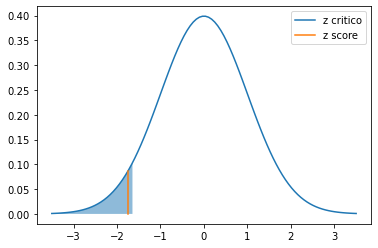

In [10]:
critical_value = z_critico

# Plot the normal distribution
samples = 100
x_plot = np.linspace(-3.5, 3.5, samples)
y_plot = stats.norm.pdf(x_plot, 0, 1)
plt.plot(x_plot, y_plot)

# Plot the critical region
x_crit = np.linspace(critical_value, -3.5, samples)
y_crit = stats.norm.pdf(x_crit, 0, 1)
# colorea la region de rechazo de H0:
plt.fill_between(x_crit,  y_crit, alpha=.5)

# Plot the z score, linea naranja:
plt.plot([Z, Z], [0, stats.norm.pdf(Z)])

# Show legend
plt.legend(['z critico', 'z score'])
plt.show()

Otra forma de tomar la decisión es mediante el cálculo del p-value: rechazamos H0 si p-value es menor que el nivel de significación alpha.

Calculemos p-value usando `stats.norm.cdf` que nos devuelve la probabilidad acumulada para el valor pasado como parámetro

In [11]:
p_value = stats.norm.cdf(Z)
p_value

0.04005915686381699

Vemos que p_value es menor que 0.05, por lo tanto rechazamos H0.

<a id="section_test_media_poblacion_normal_varianza_desconocida"></a> 
### Tests para la media de una población normal con varianza desconocida

[volver a TOC](#section_toc)


Si no conocemos la varianza poblacional y no podemos asegurar las condiciones de normalidad de la distribución de la media muestral, entonces utilizamos el estadístico de prueba T-Student con n - 1 grados de libertad.

#### Estadístico de prueba

$$T = \frac{\bar{X} - \mu0}{S / \sqrt{n}}$$

#### Ejemplo

Muestra de n = 100

Media muestral de 130.1 con una desviación estándar de 21.21.

H0: $\mu = 120$

H1: $\mu \neq 120$

 El valor del estadístico resulta:



In [12]:
T = (130.1 - 120) / (21.21 / math.sqrt(100))
T

4.761904761904759

Usando el enfoque de región crítica, calculemos los valores de t_critico_izq, t_critico_der

Para eso usamos la función `stats.t.ppf`

https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.t.html

In [13]:
alpha = 0.05
grados_libertad = 99
t_critico = stats.t.ppf(alpha / 2, df=grados_libertad)
t_critico

-1.9842169515086832

Rechazamos la hipótesis nula  al nivel $\alpha = 0.05$ si 

$T \ge T_{0.025, 99} = 1.9842$ 

o si 

$T \le T_{0.025, 99} = -1.9842$

Por lo tanto, rechazamos la hipótesis nula: T = 4.762 > 1.9842 porque T cae en la región de rechazo

T:  4.761904761904759


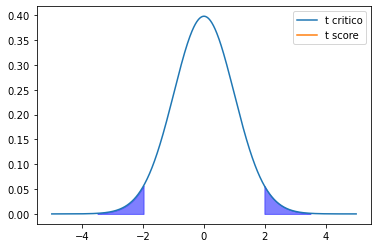

In [14]:
critical_value = t_critico

# Plot the normal distribution
samples = 1000
x_plot = np.linspace(-5, 5, samples)
y_plot = stats.t.pdf(x_plot, df = grados_libertad)
plt.plot(x_plot, y_plot)

# Plot the critical region
x_crit_left = np.linspace( critical_value, -3.5, samples)
x_crit_right = np.linspace(- critical_value, 3.5, samples)
y_crit_left = stats.t.pdf(x_crit_left, df = grados_libertad)
y_crit_right = stats.t.pdf(x_crit_right, df = grados_libertad)
# colorea la region de rechazo de H0:
plt.fill_between(x_crit_left, y_crit_left, alpha=.5, color = "blue")
plt.fill_between(x_crit_right, y_crit_right, alpha=.5, color = "blue")

# Plot the z score, linea naranja:
plt.plot([T, T], [0, stats.t.pdf(T, df = grados_libertad)])
print('T: ', T)
# Show legend
plt.legend(['t critico', 't score'])
plt.show()

Tenemos la misma conclusión al usar el enfoque del p-value. 

Este enfoque nos dice que rechacemos la hipótesis nula al nivel $\alpha = 0.05$ si el valor $ p-value \lt \alpha / 2 = 0.025$

La probabilidad de obtener un valor como T o más extremo es 1 - probabilidad acumulada en T. Este valor es menor que 0.025 por lo tanto rechazamos H0

In [15]:
p_value = 1 - stats.t.cdf(T, df = grados_libertad)
p_value

3.281350908546088e-06

<a id="section_test_proporcion"></a> 
### Test para la proporción

[volver a TOC](#section_toc)

#### Ejemplo

Se tira un dado con 4 caras (tetraedro) 1000 veces y se registra que salen 290 veces el número 4.

¿Hay evidencia para concluir que el dado está sesgado, es decir, que se observan más veces el número 4 que lo esperado?

Si el dado está equilibrado, cada cara tiene probabilidad 0.25 de aparecer. Supongamos inicialmente que este es el caso:

H0: p = 0.25

En base  a la muestra la proporción observada resulta:

In [16]:
p_hat = 290 / 1000
p_hat

0.29

Según el Teorema Central del Límite, la proporción muestral tiene distribución asintóticamente normal con media (bajo H0) p0 = 0.25 y desvío estándar (bajo H0) 

$$\sqrt \frac {p_0 (1 - p_0)}{n}$$

Por lo que, bajo H0, este estadístico tiene distribución normal estándar (con media 0 y desvío 1):

$$Z = \frac {\hat{p} - p_0} {\sqrt \frac {p_0 (1 - p_0)}{n}}$$

Establecemos

H0: probabilidad de obtener un 4 = 0.25

H1: probabilidad de obtener un 4 > 0.25

Nivel de significación alfa: 0.05

Calulamos el valor de `z_critico`

In [17]:
alpha = 0.05
z_critico = (-1) * stats.norm.ppf(alpha)
z_critico

1.6448536269514729

Entonces rechazamos si Z es mayor que `z_critico`

In [18]:
p0 = 0.25 # p bajo H0
Z = (p_hat - p0) / (math.sqrt(p0 * (1-p0) / 1000))
Z

2.9211869733608844

Como `Z` es mayor que `z_critico`, rechazamos H0

<a id="section_interpretacion_alfa"></a> 
### Interpretación del nivel de significación $\alpha$ de un test

[volver a TOC](#section_toc)


**El nivel de significación indica la proporción de veces que nos vamos a equivocar rechazando $ H_0 $ cuando $ H_0 $ es verdadera, al tomar muestras de la misma población y aplicar la regla de decisión basados en un valor crítico (que fue elegido en base a un nivel de significación $\alpha$ ).** 

Para ver eso, generemos un array de 5000 puntos con distribución normal de media 2 y desvío 1. Consideramos a esta serie nuestra población. 
Platenamos como 

H0: $\mu = 2$

H1: $\mu \neq 2$

El nivel de significación del test es 0.05, es un test a dos colas (porque rechazamos a H0 con valores muy bajos o muy altos)

Ahora vamos a generar 1000 muestras de la población con 100 elementos cada una y vamos a testear H0 en cada una de esas muestras.

El estadístico de test es 

$$Z = \frac{\bar{X} - \mu0}{\sigma / \sqrt{n}}$$

Y contamos la cantidad de rechazos en esas muestras.


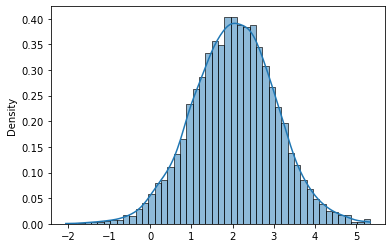

In [19]:
random_generator = np.random.default_rng()
data_poblacion = random_generator.normal(loc=2, scale=1, size = 5000)
sns.histplot(data_poblacion, kde = True, stat = 'density');

Como el test es a dos colas, necesitamos dos valores críticos:
* z_critico_izq que es el valor que deja a su izquierda una probabilidad acumulada de 0.025 (la mitad de la significación del test)    
* z_critico_der que es el valor que deja a su izquierda una probabilidad acumulada de 0.975 (=1-0.025) (la otra mitad de la significación del test, por derecha)    

Como la distribución es simétrica, z_critico_izq es igual a -1 * z_critico_der

Observemos que usamos los mismo valores críticos para evaluar la hipótesis en todas las muestras, porque los valores críticos dependen solamente de 
* el valor de significación del test, 
* la distribución del estadístico de test, N(0,1) en este caso

In [20]:
alpha = 0.05
z_critico_izq = stats.norm.ppf(alpha/2)
z_critico_der = stats.norm.ppf(1 - alpha/2)
print(z_critico_izq, z_critico_der)

-1.9599639845400545 1.959963984540054


In [21]:
sample_count = 1000
sample_size = 100

mu_0 = 2
sd = 1

rechazos = []

for i in range(sample_count):
    # creo la muestra
    data_sample = random_generator.choice(data_poblacion, size = sample_size,  replace=False)
    media_muestral = data_sample.mean()
    # calculo Z
    Z = (media_muestral - mu_0 ) / (sd/math.sqrt(sample_size))
    # aplico la regla de decisión
    rechazo = (Z < z_critico_izq) or (Z > z_critico_der)
    # guardo el resultado en la lista rechazos
    rechazos.append(rechazo)


print("proporción de rechazos: ", sum(rechazos) / sample_count)

proporción de rechazos:  0.06


Vemos entonces que la proporción de rechazo equivocado (porque sabemos que la población realmente tienen media 2 porque así la construímos) es aproximadamente el valor de alfa.

Como ejercicio pueden modificar los valores de las variables `alpha` `sample_count` `sample_size` y verificar que esta relación se sigue cumpliendo.

<a id="section_resumen"></a> 
## En resumen

[volver a TOC](#section_toc)


Para todos los casos de test que vimos vamos a:

* Plantear H0 y H1 sobre el parámetro poblacional

* Definir el valor de significación del test ($\alpha$)

* Definir una regla de rechazo dependiendo del tipo de relación <, > o !=

* Calcular el valor del estadístico de prueba, que es una transformación del valor observado / calculado sobre la muestra.

* Calcular los valores críticos / Calcular el p-value

* Aplicar la regla de rechazo con el valor del estadístico de prueba y los valores críticos / el p-value

---

<a id="section_tipos_error"></a> 
## Tipos de error en test de hipótesis

[volver a TOC](#section_toc)


Al realizar un test de hipótesis, podemos incurrir en dos tipos de errores:

* Error de Tipo I

* Error de Tipo II


|Comparación|TYPE I ERROR|TYPE II ERROR|
|---|:---:|:---|
|Significado|rechazo H0 cuando H0 es verdadera|no rechazo H0 cuando H0 es falsa|
|Equivalente a|Falso positivo|Falso negativo|
|¿Qué es?|Es un rechazo incorrecto de la hipótesis nula que es verdadera|Es un no rechazo incorrecto de la hipótesis nula que es falsa |
|Representa| Un falso hit|Un miss|
|Probabilidad de cometer este error|Igual al nivel de significación del test|Igual al poder del test|
|Se representa como|$\alpha$|$\beta$|

---

![Image](img/possible-outcomes.jpg)

---

Alfa y Beta varían en forma inversa… ¿por qué?

![Image](img/errores_tipo_1_2.png)



<a id="section_ab_testing"></a> 
## A/B Testing

[volver a TOC](#section_toc)


### Ejemplo

Una de tus principales responsabilidades es la optimización de las conversiones.

Uno de tus anunciantes ha desarrollado un nuevo producto, y el VP de Advertisements quiere tu ayuda eligiendo entre el anuncio A y el anuncio B.

Decidís aplicar  A/B testing para definir cuál es el mejor anuncio.

$N_A$ es la cantidad de personas ven el anuncio A y que de éstas, $n_A$ hacen click en él.

Podemos pensar en cada vista de un anuncio como una prueba de Bernoulli donde $p_A$ es la probabilidad que alguien haga click en el anuncio A.

Entonces, si $N_A$ es grande, como es el caso aquí, sabemos que $n_A/N_A$ es aproximadamente una variable aleatoria normal con media $p_A$ y desvío estándar  $\sigma_A = \sqrt{\frac {p_A (1 - p_A)} {N_A}}$

Analogamente, $n_B/N_B$ es aproximadamente una variable aleatoria normal con media $p_B$ y desvío estándar $\sigma_B = \sqrt{\frac {p_B (1 - p_B)} {N_B}}$

Si asumimos que estas dos normales son independientes (lo que parece razonable porque las pruebas Bernoulli individuales deben serlo), entonces su diferencia debe ser también normal con media  pB- pA y  desvío estándar  

Si asumimos que estas dos normales son independientes (parece razonable porque las pruebas Bernoulli individuales deben serlo), entonces su diferencia debe ser también normal con media $p_B - p_A$ y  desvío estándar $\sqrt{\sigma_A^2 + \sigma_B^2}$

Esto significa que podemos testear la hipótesis nula

H0: $(p_B - p_A) = 0$

usando el estadístico que tiene distribución aproximada $N(0,1)$:

$Z = \frac{p_B - p_A}{\sqrt{\sigma_A^2 + \sigma_B^2}}$


![Image](img/AB_testing.png)